# NLP : analyses de texte et de sentiments des retours sur des films

## Table des matières
- [Introduction](##Intoroduction)
- [Lecture des données](##Lecture-des-données)
- [Formatage données textuelles](##Formatage-données-textuelles)
- [Matrice documents x termes](##Matrice-documents-x-termes)
- [AFC](##AFC)
- [Nuage de mots](##Nuage-de-mots)
- [Entités nommées](##Entités-nommées)
- [Classificateur](##Classificateur)
- [Conclusion](##Conclusion)

## Introduction

Le Traitement Automatique de Langage(TAL) est une branche de l'informatique qui traite l'information portée par une langue ou un langage naturel. Pour appliquer le TAL, nous avons à notre disposition un jeu de données composé de critiques (avis positifs ou négatifs) sur des films. 
Quelle est la répartition des avis? De quoi sont composées les critiques? Quelle est le modèle pour prédire la positivité(ou negativité) des critiques?
Nous répondrons à ces questions lors de notre étude

#### Imports

In [1]:
!pip install spacy-langdetect
!pip install vaderSentiment

In [2]:
import pandas as pd
import numpy 
import os
import matplotlib.pyplot as plt
import sys
import nltk
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis
from nltk.text import Text
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.decomposition import LatentDirichletAllocation
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from unidecode import unidecode
from  spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from nltk.tokenize import word_tokenize
from gensim.test.utils import datapath
from gensim import utils
import gensim.downloader
from xgboost import XGBClassifier
import lightgbm as lgb
from wordcloud import WordCloud
import optuna 
import pandas as pd
import numpy as np
import plotly_express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from itertools import permutations

c:\Users\monke\Anaconda\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\monke\Anaconda\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\monke\Anaconda\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword 

## Lecture des données

In [ ]:
data = pd.read_csv("path//IMDB Dataset.csv")

data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
data.shape

(50000, 2)

In [6]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

Notre jeu de données est composé de 50000 lignes et 2 colonnes qui sont:
- review: qui concerne l'avis sur un film;
- sentiment: qui concerne le type d'avis. c'est-à-dire si l'avis est positif ou négatif.

Nous notons qu'il n'y a aucune données nulle sur ce jeu de données et qu'il y a autant d'avis positifs que de négatifs. Ce qui est une bonne structure.
Cependant, sur la colonne review, les textes comportent des caractères non importants et qui pourraient biaiser notre étude. De ce fait, nous les supprimerons sur la cellule suivante.

In [7]:
for i in range(len(data.review)):
    data['review'][i]=data['review'][i].replace("<br />","")

data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Formatage données textuelles

Cette partie concerne le choix de formatage des données textuelles. En effet, cette étape est tres importante du fait qu'elle puisse changer les résultats de l'étude. De ce fait, nous pensons que pour le traitement des avis sur un film, la tokenization et la lemmatisation suffisent largement.

#### Detection de Langue

In [8]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

langues = []

for text in data.review:
    avis=nlp(text)
    langues+=[avis._.language["language"]]
    
data["Langue"] = langues

Nous avons créé une colonne nommée "Langue" qui stocke la langue de chaque avis.<br>
En effet, les avis sont faits en anglais.

#### Tokenization

La tokenization est un procédé permettant de remplacer une donnée textuelle par un élément équivalent appelé token, et qui n'aura aucune valeur intrinsèque ou signification exploitable une fois sortie du système.<br>
Donc, nous transformerons chaque mots en token d'une part et chaque phrase en token d'autre part.<br>
Nous créerons ensuite, sur le jeu de données initial, une colonne "words" qui concernera la tokenization par mot; une colonne "sentences" qui concernera la tokenization par phrase. 

In [9]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
words =[] 
for i in range(len(data)):
    words+=[nltk.word_tokenize(data.loc[i,"review"])]
data["words"]=words
sentences =[] 
for i in range(len(data)):
    sentences+=[nltk.sent_tokenize(data.loc[i,"review"])]
data["sentences"]=sentences
#data.head()

#### Lemmatisation

La lemmatisation est un procédé qui consiste a transformer les mots en lemme grammaticale. C'est à dire de donner à chaque mot sa forme canonique. <br>
Ce qui est très important car si un mot est écrit au masculin puis au feminin sur une autre partie du texte, on doit savoir que c'est le meme mot.<br>
D'où l'importance de cette étape.<br>
Cependant, nous ne prenons pas en compte les "stop words", les nombres et les ponctuations.<br>
Nous créerons ensuite une colonne "review_lemmatized" qui correspond a la transformation de la critique en lemme grammaticale(Par exemple, chaque verbe sera à l infinitif, ...).

In [10]:
#spacy.cli.download("en_core_web_sm")
if data.Langue[0]=="en":
    nlp = spacy.load("en_core_web_sm")
elif data.Langue[0]=="fr":
    nlp = spacy.load("fr_core_news_sm")

review_lemmatized = []

review_lemmatized= data.review.apply(lambda x: 
                                       " ".join(token.lemma_ for token in nlp(x)
                                                if (not token.is_stop and not token.is_punct and not token.like_num and token.pos_ in ['PROPN', 'NOUN', 'ADJ'])))

data['review_lemmatized'] = review_lemmatized
data.head()

,review,sentiment,Langue,words,sentences,review_lemmatized
0,One of the other reviewers has mentioned that ...,positive,en,"[One, of, the, other, reviewers, has, mentione...",[One of the other reviewers has mentioned that...,reviewer oz episode right thing Oz brutality s...
1,A wonderful little production. The filming tec...,positive,en,"[A, wonderful, little, production, ., The, fil...","[A wonderful little production., The filming t...",wonderful little production technique unassumi...
2,I thought this was a wonderful way to spend ti...,positive,en,"[I, thought, this, was, a, wonderful, way, to,...",[I thought this was a wonderful way to spend t...,wonderful way time hot summer weekend air thea...
3,Basically there's a family where a little boy ...,negative,en,"[Basically, there, 's, a, family, where, a, li...",[Basically there's a family where a little boy...,family little boy Jake zombie closet parent ti...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,"[Petter, Mattei, 's, ``, Love, in, the, Time, ...","[Petter Mattei's ""Love in the Time of Money"" i...",Petter Mattei love Time money stunning film Mr...


#### Analyse de sentiment

L'analyse de sentiment, également appelée exploration des opinions ou intelligence artificielle des émotions, est une technique de traitement du langage naturel (NLP) qui détermine si un élément de contenu est positif, négatif ou neutre. <br>
De ce fait, nous allons l'utiliser afin d'analyser les avis sur les films afin de savoir s'ils sont positifs ou négatifs.

In [11]:
analyzer = SentimentIntensityAnalyzer()
type_review=[] # sentiments issus de notre analyse

for i in range(len(data)):
    liste_sentiment_par_review=[]
    sentiment_globale_polarity=0
    for phrase in data.loc[i,"sentences"]:
        sentiment = analyzer.polarity_scores(phrase)
        liste_sentiment_par_review.append(sentiment['compound']) 
    sentiment_moyenne = np.mean(liste_sentiment_par_review)
    if sentiment_moyenne > 0:
        type_review+=["positive"]
    elif sentiment_moyenne < 0:
        type_review+=["negative"]
    elif sentiment_moyenne == 0:
        type_review+=["neutral"]

In [12]:
sentiment_accuracy = accuracy_score(data["sentiment"],type_review)

sentiment_cm = confusion_matrix(y_true=data["sentiment"],y_pred=type_review)

print(f"Confusion matrix of the sentiment analysis: \n")
print(f"{sentiment_cm}")
print(f"\n The accuracy score of the analysis is : {sentiment_accuracy}")

Confusion matrix of the sentiment analysis: 

[[13521    11 11468]
 [    0     0     0]
 [ 3325     8 21667]]

 The accuracy score of the analysis is : 0.70376


Après avoir fait notre propre analyse de sentiment, nous avons comparé nos résultats avec les sentiments déjà présentes sur le jeu de données initial. <br>
Nous trouvons une précision de 70%; ce qui est plutot rassurant sur un jeu de données contenant 50000 avis.<br>
Cependant, la matrice de confusion est de dimension 3x3 car nous avons ajouté un sentiment "neutre" (dans notre analyse de sentiments) qui ne faisait pas partie des sentiments présentes dans le jeu de données.

## Matrice documents x termes

C'est à partir de cette partie que l'analyse des critiques débute.<br>
La matrice documents x termes nous sert à comparer des textes et à trouver les lemmes les plus présentes sur l'ensemble de tous les avis.<br>
Pour cela nous utiliserons la colonne "review_lemmatized". Ceci dans le but de ne pas avoir à etre confronté au problème des mots appartenant à une meme lemme mais ecrit différemment. 

In [13]:
vec = CountVectorizer(stop_words='english', max_features=500, lowercase=True, min_df=20, encoding='utf-8')
# max_features : top max_features ordered by term frequency across the corpus
X = vec.fit_transform(data.review_lemmatized)
# X sparse doit être transformé en matrice non sparse pour les traitements ultérieurs
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
print(df.head(4))
print(df.shape)

   ability  able  accent  act  acting  action  actor  actress  actual  adult  \
0        0     0       0    0       0       0      0        0       0      0   
1        0     0       0    0       0       0      1        0       0      0   
2        0     0       0    0       0       0      0        0       0      0   
3        0     0       0    0       0       0      0        0       0      0   

   ...  work  world  worth  writer  writing  wrong  year  york  young  zombie  
0  ...     0      0      0       0        0      0     0     0      0       0  
1  ...     0      0      1       0        0      0     0     0      0       0  
2  ...     0      0      0       0        0      0     1     0      1       0  
3  ...     0      0      0       0        0      0     0     0      0       2  

[4 rows x 500 columns]
(50000, 500)


Nous remarquons que sur l'ensemble des 50000 avis, 500 lemmes ont été utilisées(sans compter les "stop words", les nombres et les ponctuations). 

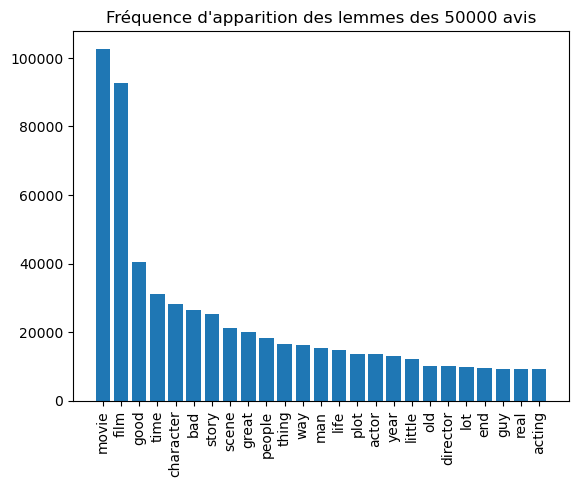

In [14]:
freqs = [(word, X.getcol(idx).sum()) for word, idx in vec.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:25]], [x[1] for x in freqs[:25]])
plt.xticks(rotation=90)
plt.title("Fréquence d'apparition des lemmes des 50000 avis")
plt.show()

L'histogramme ci-dessus nous montre les 25 lemmes les plus présentes sur l'ensemble des 50000 avis.<br>
Nous remarquons que movie et film sont les lemmes les plus présentes. Ce qui est tout à fait normal, car les textes concernent des avis sur des films.<br>
Ensuite, en 3e position, vient la lemme "good" apparu au moins 35000 fois. Ce qui peut signifier que sur les avis négatifs, on peut imaginer qu'il y ait un bon coté.<br> 
Ou bien sur les avis positifs, cette lemme a été utilisée beaucoup de fois. Ce qui veut dire que beaucoup d'éléments du film ont plu à ceux qui ont émis ces avis. 

## AFC

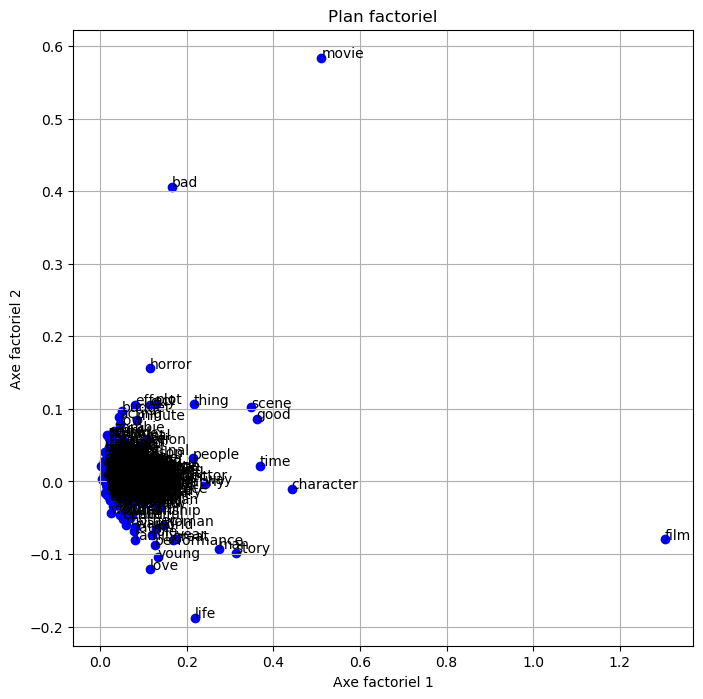

In [15]:
n_components = 2
fa = FactorAnalysis(n_components=n_components)
fa.fit(df)

#Affichage des mots
plt.figure(figsize=(8, 8))
plt.scatter(fa.components_[0], fa.components_[1], color='blue')
for i, var in enumerate(df.columns):
    plt.annotate(var, (fa.components_[0][i], fa.components_[1][i]), color='black')
plt.xlabel("Axe factoriel 1")
plt.ylabel("Axe factoriel 2")
plt.title("Plan factoriel")
plt.grid()
plt.show()

L'AFC nous montre que le mot "film" a fortement contribué à la création de l'axe factoriel 1;<br>
De la meme manière, le mot "movie" a fortement contribué à la création de l'axe factoriel 2.<br>
On remarque aussi que le mot "bad" est souvent associé au mot "movie". Ce qui peut correspondre aux avis négatifs.<br>
De plus nous avons l'association de "good" à "scene", à "time", à "people", à "thing" et à "character".<br>
Cette structure nous donne une idée sur la différence entre les avis positifs et ceux négatifs. <br>
En effet, les avis négatifs ne se focalisent que sur le film; alors que ceux positifs mettent en exergue différentes notions comme les personnages, l'histoire, etc.

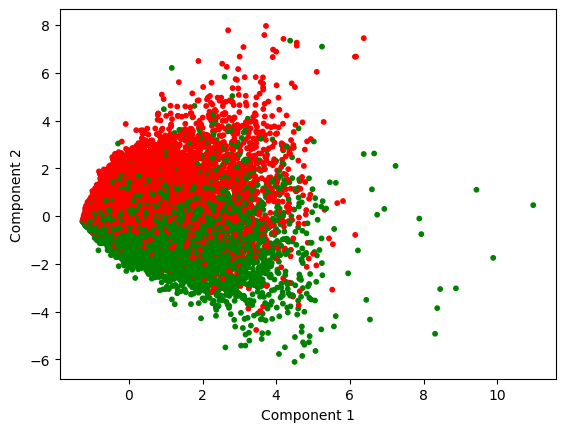

In [16]:
#affichage des individus
components = fa.transform(df)
df_components = pd.DataFrame(components, columns=['Component_1', 'Component_2'])
df_components['sentiment'] = data['sentiment']
colors = {'negative': 'red', 'positive': 'green'} 
plt.scatter(df_components['Component_1'], df_components['Component_2'], c=df_components['sentiment'].map(colors), s=10)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

#### Analyse de thématiques

C'est une technique de modélisation des documents de texte qui cherche à trouver une structure sémantique cachée dans les documents. <br>
Elle réinterprète les textes sous forme mathématique afin d'isoler les termes les plus pertinents et les associer par proximité.

In [17]:
lda = LatentDirichletAllocation(n_components=10, random_state=123, doc_topic_prior=0.2, n_jobs=4)
lda_matrix = lda.fit_transform(X)
dominant_topics = lda_matrix.argmax(axis=1)

In [18]:
# Print the topics with their terms
terms = vec.get_feature_names_out()

# Get Components 
lda_components=lda.components_

In [19]:
# fonction qui permet d'afficher les thematiques
def plot_top_words(model, feature_names, n_top_words, title):
    nombre_colonnes = int(len(lda_components) / 2)
    fig, axes = plt.subplots(2, nombre_colonnes, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index, topic in enumerate(lda_components):
        top_features_key = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_key]
        weights = topic[top_features_key]
        
        ax = axes[index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {index +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.1, wspace=0.50, hspace=0.25)
    plt.show()

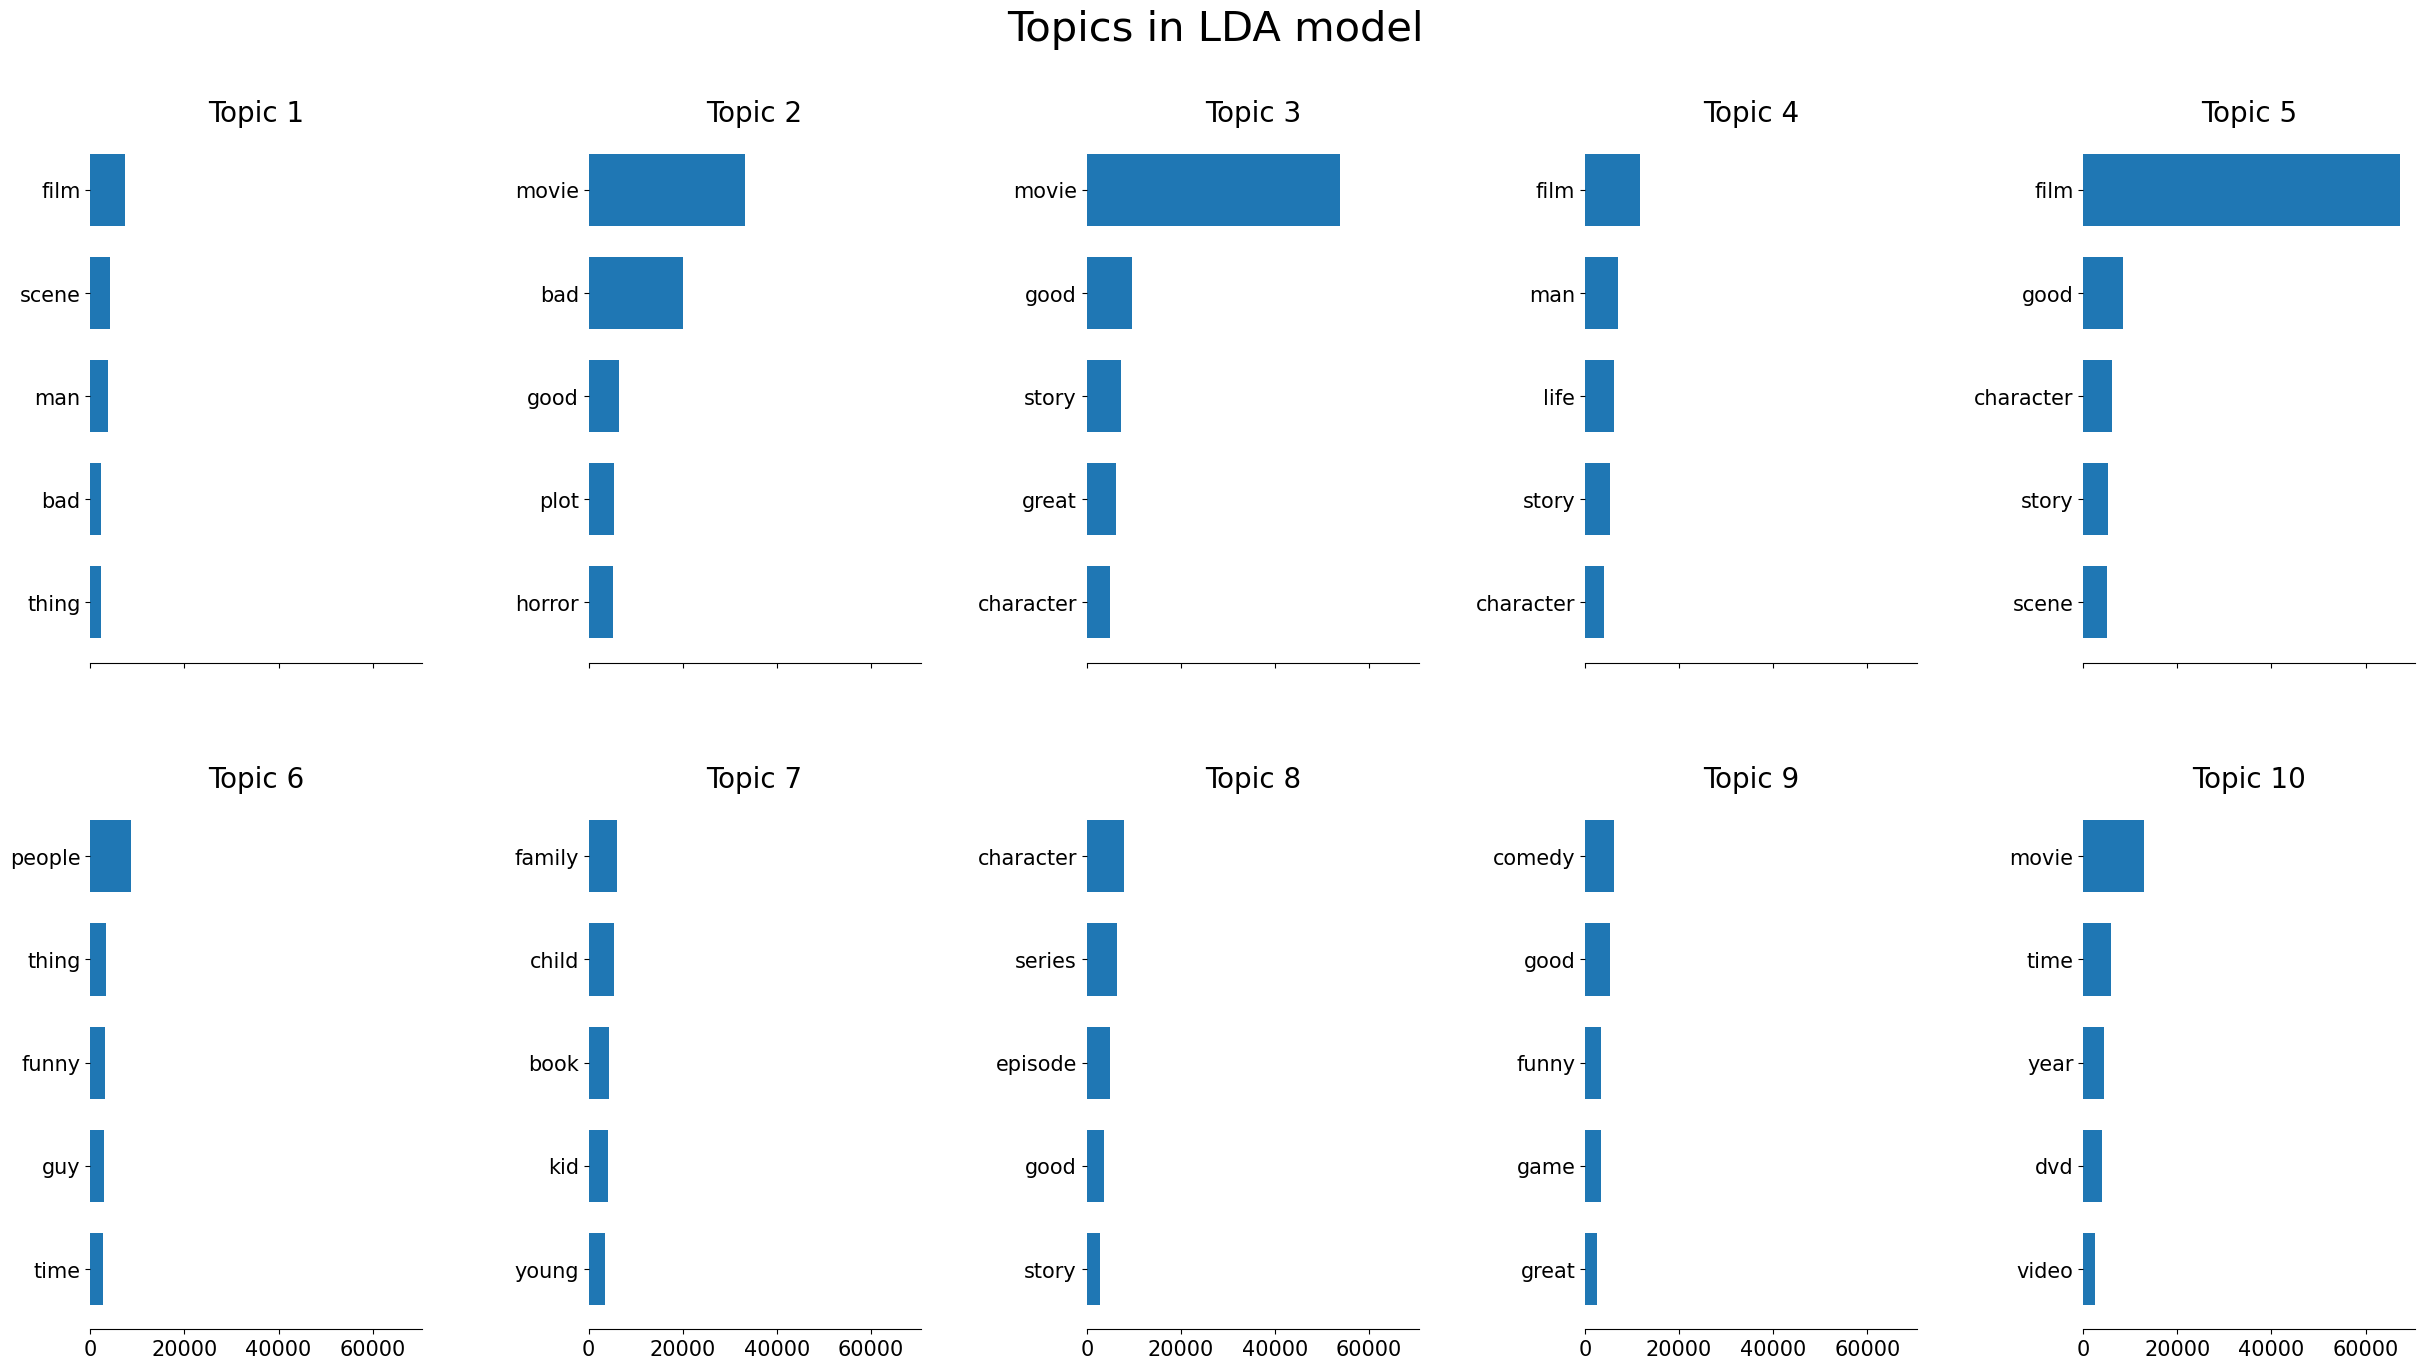

In [20]:
n_top_words = 5
plot_top_words(lda, terms, n_top_words, "Topics in LDA model")

Nous remarquons que sur les 50000 avis sur les films, la thématique la plus abordée est "film" ou "movie".<br>
Ce qui est très logique, compte tenu de la nature meme des données(données des avis sur des films). <br>
La thématique 1: on remarque qu'elle concerne une ou des scènes du films.<br>
La thématique 2: elle concerne l'intrigue du films.<br>
La thématique 3: elle concerne l'histoire et les personnages du films.<br>
La thématique 4: elle concerne l'histoire et les personnages du films.<br>
La thématique 5: elle concerne l'histoire, les personnages et les scènes du films.<br>
La thématique 6: elle concerne les personnages, le temps, une personne drole.<br>
La thématique 7: elle concerne la famille et les enfants.<br>
La thématique 8: elle concerne l'histoire et les personnages de la serie.<br>
La thématique 9: elle concerne la comédie et les jeux.<br>
La thématique 10: elle concerne la durée et l'année du films.<br>
En résumé, les thématiques les plus abordées sur ces avis sont:
- Les personnages (ou acteurs);
- L'histoire;
- La durée;
- L'intrigue;
- Le genre;
- Les scènes.

## Nuage de mots

 Le nuage de mots fait apparaître les mots essentiels qui caractérisent une notion, un concept ou le raisonnement développé dans un document. Le nuage de mots est construit à partir de l'occurrence des termes utilisés : plus un terme revient, plus il sera mis en valeur.<br>
 Ce qui a le meme but que l'histogramme des fréquences des lemmes.<br>
 Mais la représentation est différente.

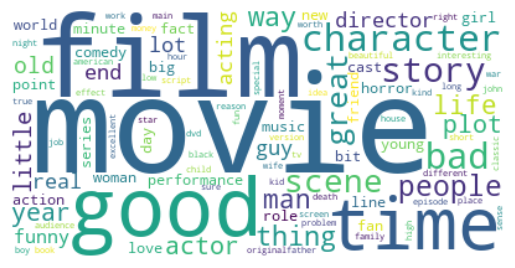

In [21]:
# nuage de mots à partir de la matrice documents x termes
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(df.T.sum(axis=1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Ce visuel a été créé a partir de la matrice documents termes.<br>
On peut confirmer que les 5 lemmes les plus présentes sont: "movie", "film", "good", "time" et "character".<br>
Ce qui est cohérent par rapport au diagramme des fréquence des lemmes.

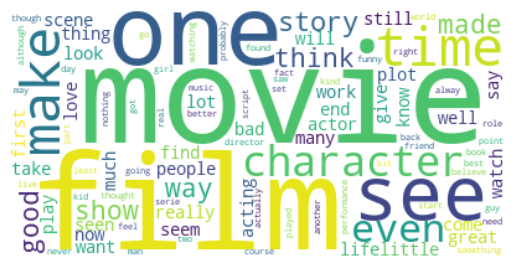

In [22]:
# nuage de mots à partir de la liste des mots
mots = []
for element in data.review:
    if isinstance(element, str):
        mots.extend(element.split())

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate(" ".join(mots))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig("wordcloud.png")
plt.show()

Celui-ci a été créé a partir de la colonne "review_lemmatized".<br>
On remarque une petite différence avec celui créé à partir de la matrice documents termes.<br>
En effet, les 5 lemmes les plus représentées sont: "film", "movie", "one", "see" et "character".<br>
Cette méthode prend en compte les adjectifs numéraux et les verbes. Ce qui le différencie de la méthode avec la matrice documents termes.<br>
Ce qui explique la différence entre les deux représentations.

## Entités nommées

Sur cette partie, nous étudierons les entités nommées. Ces dernières sont des mots spécifiques (par exemple nom propre, nom d'un lieu, etc).

In [23]:
#Fonction qui retourne le mot le plus frequent d'une liste
def most_frequent(List):
    num="Sans entite nomme"
    if(len(List) > 0):
        counter = 0
        num = List[0]
     
        for i in List:
            curr_frequency = List.count(i)
            if(curr_frequency> counter):
                counter = curr_frequency
                num = i
 
    return num

#Fonction qui retourne chaque mot d'une liste et sa frequence
def frequence(List):
    counter = 0
    num = set(List[0])
    l=[]
     
    for i in set(List):
        counter = List.count(i)
        num = i
        l+=[(num,counter)]
 
    return l

In [24]:
entite_nomme=[]
for i in range(len(data.review)):
    text=data.review[i]
    doc=nlp(text)
    categories=[]
    compte=0
    for ent in doc.ents:
        categories+=[ent.label_]
    plus_freq=most_frequent(categories)
    entite_nomme+=[plus_freq]

data["entite_nomme"] = entite_nomme
    

Sur la cellule d'au-dessus, nous avons pris pour chaque review(chaque ligne du jeu de données), le type d'entité nommée le plus représenté(si ce type existe).<br>
Ensuite nous avons créé une colonne où on stocke cette entité nommée.

In [25]:
coordonnees=[]

for mots in frequence(list(data["entite_nomme"])):
    coordonnees+=[(mots[0],mots[1])]
    
coordonnees_trier = sorted(coordonnees,key=lambda x: -x[1])
abscisse=[mots[0] for mots in coordonnees_trier]
ordonnees=[mots[1] for mots in coordonnees_trier]

diagramme=pd.DataFrame({"Entite_nommee":abscisse,
                        "frequence":ordonnees})
    
px.bar(data_frame=diagramme,x='Entite_nommee', y='frequence', color='Entite_nommee',
       hover_data=diagramme,title="Fréquence des entités nommées les plus présentes dans chaque avis")


Apres avoir créé la colonne où on stocke le type d'entité nommée le plus représenté dans chaque review, nous avons établi le diagramme ci-dessus.<br>
Nous remarquons que le type d'entité nommée "Person"(réfere a une personne, c'est-à-dire nom propre) est le plus représenté parmi les 50000 avis.<br>
Ensuite, arrivent les "Cardinal" qui sont des adjectifs numéraux cardinaux.<br>
Puis en 3e position, on remarque "Org" qui représente les organisations.

## Classificateur

Cette partie concerne la modélisation. En effet, nous devons séparer le jeu de données en jeu pour entrainer les modèles et en jeu pour tester le modèle et ses prédictions.<br>
C'est une étape nécessaire, car si nous avons un nouvel avis sans savoir si il est positif ou négatif, le modèle pourrait le prédire si il est bon.<br>
De ce fait, nous allons comparer 6 différents modèles de prédiction de sentiment afin d'en garder les 2 meilleurs.<br>
Pour 5 des 6 modèles, nous procéderons a une phase d'optimisation des paramètres, pour sélectionner les meilleurs paramètres et entrainer le modèle. Ensuite on en tire les métriques pour les comparer.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df, data.sentiment, test_size=0.30, random_state=123, stratify=data.sentiment)

#### Naive BAYES

In [27]:
# étape préalable uniquement avec des vecteurs Word2Vec car ils peuvent avoir des valeurs négatives non acceptées par la fonction MultinomialNB
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create the model, train it on the train dataset and print the scores
bayes = MultinomialNB(fit_prior=True)
bayes.fit(X_train, y_train)
print("empirical log probability for each class:", bayes.class_log_prior_)
y_pred = bayes.predict(X_test)
bayes_train_score = bayes.score(X_train, y_train)
bayes_test_score = bayes.score(X_test, y_test)
bayes_accuracy = accuracy_score(y_test,y_pred)

bayes_cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
bayes_sensitivity = bayes_cm[0,0]/(bayes_cm[0,0]+bayes_cm[0,1])
bayes_specificity = bayes_cm[1,1]/(bayes_cm[1,0]+bayes_cm[1,1])


empirical log probability for each class: [-0.69314718 -0.69314718]


#### SVM

In [28]:
def objective_svm(trial):   
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf","sigmoid"])
    C = trial.suggest_float("C", 1, 100, step=0.1)
    gamma = trial.suggest_float("gamma", 1e-3, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 10, 1000, step=10)
    model = SVC(kernel=kernel, gamma=gamma, C=C, max_iter=max_iter)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study_svm = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=3, show_progress_bar = True, gc_after_trial=True)
study_svm.optimize(objective_svm, timeout=300, show_progress_bar = True, gc_after_trial=True)

[I 2023-12-09 02:39:28,948] A new study created in memory with name: no-name-82feb9fc-1a79-441a-a062-1fc1ecca0fa9


   0%|          | 00:00/05:00

c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=290).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:39:36,109] Trial 0 finished with value: 0.501 and parameters: {'kernel': 'sigmoid', 'C': 60.0, 'gamma': 0.017359911263653847, 'max_iter': 290}. Best is trial 0 with value: 0.501.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=210).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:39:41,804] Trial 1 finished with value: 0.5010666666666667 and parameters: {'kernel': 'sigmoid', 'C': 18.900000000000002, 'gamma': 0.009305288739956452, 'max_iter': 210}. Best is trial 1 with value: 0.5010666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=490).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:39:54,243] Trial 2 finished with value: 0.5169333333333334 and parameters: {'kernel': 'sigmoid', 'C': 63.300000000000004, 'gamma': 0.03113066660864554, 'max_iter': 490}. Best is trial 2 with value: 0.5169333333333334.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=340).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:40:03,179] Trial 3 finished with value: 0.5008666666666667 and parameters: {'kernel': 'sigmoid', 'C': 64.5, 'gamma': 0.016225257557966034, 'max_iter': 340}. Best is trial 2 with value: 0.5169333333333334.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:40:10,846] Trial 4 finished with value: 0.49993333333333334 and parameters: {'kernel': 'poly', 'C': 29.200000000000003, 'gamma': 0.061973926198003425, 'max_iter': 300}. Best is trial 2 with value: 0.5169333333333334.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=950).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:40:36,223] Trial 5 finished with value: 0.49993333333333334 and parameters: {'kernel': 'poly', 'C': 63.1, 'gamma': 0.047802864312332216, 'max_iter': 950}. Best is trial 2 with value: 0.5169333333333334.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:40:37,003] Trial 6 finished with value: 0.5000666666666667 and parameters: {'kernel': 'poly', 'C': 3.9000000000000004, 'gamma': 0.003880954468663662, 'max_iter': 10}. Best is trial 2 with value: 0.5169333333333334.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=270).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:40:44,099] Trial 7 finished with value: 0.5006 and parameters: {'kernel': 'sigmoid', 'C': 39.800000000000004, 'gamma': 0.002186922235849351, 'max_iter': 270}. Best is trial 2 with value: 0.5169333333333334.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=680).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:40:59,228] Trial 8 finished with value: 0.5591333333333334 and parameters: {'kernel': 'linear', 'C': 72.60000000000001, 'gamma': 0.003207551002546666, 'max_iter': 680}. Best is trial 8 with value: 0.5591333333333334.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=70).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:41:01,508] Trial 9 finished with value: 0.5695333333333333 and parameters: {'kernel': 'linear', 'C': 96.7, 'gamma': 0.00488875099792883, 'max_iter': 70}. Best is trial 9 with value: 0.5695333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:41:02,300] Trial 10 finished with value: 0.5132666666666666 and parameters: {'kernel': 'linear', 'C': 95.2, 'gamma': 0.005324948624605744, 'max_iter': 10}. Best is trial 9 with value: 0.5695333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=760).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:41:19,882] Trial 11 finished with value: 0.5474666666666667 and parameters: {'kernel': 'linear', 'C': 93.0, 'gamma': 0.0010824653010593698, 'max_iter': 760}. Best is trial 9 with value: 0.5695333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=740).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:41:36,530] Trial 12 finished with value: 0.54 and parameters: {'kernel': 'linear', 'C': 77.60000000000001, 'gamma': 0.0029521462308414632, 'max_iter': 740}. Best is trial 9 with value: 0.5695333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=650).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:41:56,784] Trial 13 finished with value: 0.5079333333333333 and parameters: {'kernel': 'rbf', 'C': 83.2, 'gamma': 0.006430637091061034, 'max_iter': 650}. Best is trial 9 with value: 0.5695333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=520).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:42:08,631] Trial 14 finished with value: 0.5864666666666667 and parameters: {'kernel': 'linear', 'C': 75.3, 'gamma': 0.0017971838349909724, 'max_iter': 520}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=520).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:42:20,401] Trial 15 finished with value: 0.5864666666666667 and parameters: {'kernel': 'linear', 'C': 99.4, 'gamma': 0.0015210170275774663, 'max_iter': 520}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=480).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:42:35,460] Trial 16 finished with value: 0.5018666666666667 and parameters: {'kernel': 'rbf', 'C': 83.30000000000001, 'gamma': 0.001082212105938074, 'max_iter': 480}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=590).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:42:48,916] Trial 17 finished with value: 0.5634 and parameters: {'kernel': 'linear', 'C': 52.5, 'gamma': 0.0018282382782246504, 'max_iter': 590}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=880).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:43:08,346] Trial 18 finished with value: 0.563 and parameters: {'kernel': 'linear', 'C': 99.30000000000001, 'gamma': 0.0018203544845309524, 'max_iter': 880}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=420).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:43:18,216] Trial 19 finished with value: 0.5505333333333333 and parameters: {'kernel': 'linear', 'C': 85.60000000000001, 'gamma': 0.0010316985149300068, 'max_iter': 420}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=590).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:43:36,811] Trial 20 finished with value: 0.5015333333333334 and parameters: {'kernel': 'rbf', 'C': 73.3, 'gamma': 0.0025512272540981823, 'max_iter': 590}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=130).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:43:40,531] Trial 21 finished with value: 0.5263333333333333 and parameters: {'kernel': 'linear', 'C': 89.2, 'gamma': 0.004235371831797625, 'max_iter': 130}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=430).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:43:50,506] Trial 22 finished with value: 0.5501333333333334 and parameters: {'kernel': 'linear', 'C': 98.2, 'gamma': 0.0016661419710260635, 'max_iter': 430}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=560).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:44:03,331] Trial 23 finished with value: 0.5502 and parameters: {'kernel': 'linear', 'C': 77.9, 'gamma': 0.006621702100607629, 'max_iter': 560}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=390).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:44:12,556] Trial 24 finished with value: 0.5625333333333333 and parameters: {'kernel': 'linear', 'C': 92.30000000000001, 'gamma': 0.0031304616319995644, 'max_iter': 390}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=130).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:44:16,257] Trial 25 finished with value: 0.5263333333333333 and parameters: {'kernel': 'linear', 'C': 44.2, 'gamma': 0.0015674319458068601, 'max_iter': 130}. Best is trial 14 with value: 0.5864666666666667.


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=760).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2023-12-09 02:44:33,489] Trial 26 finished with value: 0.5474666666666667 and parameters: {'kernel': 'linear', 'C': 99.9, 'gamma': 0.0041886248759804064, 'max_iter': 760}. Best is trial 14 with value: 0.5864666666666667.


In [29]:
# problèmes multi-classe gérés de manière différente : linearSVC utilise One-vs-All et SVC utilise One-vs-One
C = study_svm.best_params["C"] # paramètre de régularisation
gamma = study_svm.best_params["gamma"] 
kernel = study_svm.best_params["kernel"] 
max_iter = study_svm.best_params["max_iter"] 

svm =  SVC(C=C, max_iter=max_iter,gamma=gamma,kernel=kernel)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm_train_score = svm.score(X_train, y_train)
svm_test_score = svm.score(X_test, y_test)
svm_accuracy = accuracy_score(y_test,y_pred)

svm_cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
svm_sensitivity = svm_cm[0,0]/(svm_cm[0,0]+svm_cm[0,1])
svm_specificity = svm_cm[1,1]/(svm_cm[1,0]+svm_cm[1,1])


c:\Users\monke\Anaconda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=520).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



#### Random Forest

In [30]:
def objective_rf(trial):    
    
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    n_estimators = trial.suggest_int("n_estimators", 1, 500, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    max_features = trial.suggest_int("max_features", 1, 10)
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, 
                                   min_samples_split=min_samples_split, max_features=max_features,
                                   random_state=123)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, timeout=300, show_progress_bar = True, gc_after_trial=True)


[I 2023-12-09 02:44:50,675] A new study created in memory with name: no-name-e4bd02cd-01d2-4632-9ef9-1d9bdb30f479


   0%|          | 00:00/05:00

[I 2023-12-09 02:45:13,232] Trial 0 finished with value: 0.8218666666666666 and parameters: {'criterion': 'entropy', 'n_estimators': 331, 'min_samples_split': 24, 'max_features': 2}. Best is trial 0 with value: 0.8218666666666666.
[I 2023-12-09 02:45:13,946] Trial 1 finished with value: 0.6531333333333333 and parameters: {'criterion': 'entropy', 'n_estimators': 2, 'min_samples_split': 19, 'max_features': 3}. Best is trial 0 with value: 0.8218666666666666.
[I 2023-12-09 02:45:14,596] Trial 2 finished with value: 0.6491333333333333 and parameters: {'criterion': 'entropy', 'n_estimators': 1, 'min_samples_split': 30, 'max_features': 6}. Best is trial 0 with value: 0.8218666666666666.
[I 2023-12-09 02:45:15,717] Trial 3 finished with value: 0.7488666666666667 and parameters: {'criterion': 'gini', 'n_estimators': 8, 'min_samples_split': 23, 'max_features': 3}. Best is trial 0 with value: 0.8218666666666666.
[I 2023-12-09 02:45:16,337] Trial 4 finished with value: 0.5932666666666667 and param

In [31]:
criterion = study_rf.best_params["criterion"] 
n_estimators = study_rf.best_params["n_estimators"] 
min_samples_split = study_rf.best_params["min_samples_split"]
max_features = study_rf.best_params["max_features"]

randomforest = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                      min_samples_split=min_samples_split, 
                                      max_features=max_features, random_state=123)
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
rf_train_score = randomforest.score(X_train, y_train)
rf_test_score = randomforest.score(X_test, y_test)
rf_accuracy = accuracy_score(y_test,y_pred)

rf_cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
rf_sensitivity = rf_cm[0,0]/(rf_cm[0,0]+rf_cm[0,1])
rf_specificity = rf_cm[1,1]/(rf_cm[1,0]+rf_cm[1,1])


#### XGBoost

In [32]:
# Initialisation de LabelEncoder
label_encoder = LabelEncoder()
# Conversion des étiquettes de classe en valeurs numériques
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.fit_transform(y_test)

In [33]:
def objective_xgb(trial):    
   
    gamma = trial.suggest_float('gamma', 1,200,step=10)
    booster = trial.suggest_categorical('booster', ["gbtree", "gblinear","dart"])
    max_depth = trial.suggest_int('max_depth', 6, 8)
    eta = trial.suggest_float('eta', 0.0001,0.9999,step=0.0001)
    alpha = trial.suggest_float('alpha', 1e-5, 10, step=0.001)
    
    model = XGBClassifier(gamma=gamma,booster=booster,max_depth=max_depth, eta=eta,
                          alpha=alpha)
    model.fit(X_train, y_train_numeric)
    return model.score(X_test, y_test_numeric)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, timeout=300, show_progress_bar = True, gc_after_trial=True)

[I 2023-12-09 02:50:57,840] A new study created in memory with name: no-name-4e63b309-13dd-4296-9f70-ce1299222cc8


   0%|          | 00:00/05:00

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[I 2023-12-09 02:51:21,766] Trial 0 finished with value: 0.7711333333333333 and parameters: {'gamma': 141.0, 'booster': 'gbtree', 'max_depth': 7, 'eta': 0.6981, 'alpha': 3.86701}. Best is trial 0 with value: 0.7711333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[I 2023-12-09 02:51:43,449] Trial 1 finished with value: 0.7774666666666666 and parameters: {'gamma': 111.0, 'booster': 'gbtree', 'max_depth': 6, 'eta': 0.8744000000000001, 'alpha': 4.39701}. Best is trial 1 with value: 0.7774666666666666.


c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[I 2023-12-09 02:52:08,207] Trial 2 finished with value: 0.775 and parameters: {'gamma': 91.0, 'booster': 'gbtree', 'max_depth': 7, 'eta': 0.1439, 'alpha': 9.80201}. Best is trial 1 with value: 0.7774666666666666.


c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[I 2023-12-09 02:54:35,685] Trial 3 finished with value: 0.8215333333333333 and parameters: {'gamma': 1.0, 'booster': 'dart', 'max_depth': 6, 'eta': 0.2349, 'alpha': 3.45101}. Best is trial 3 with value: 0.8215333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[02:54:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[I 2023-12-09 02:54:39,631] Trial 4 finished with value: 0.5 and parameters: {'gamma': 131.0, 'booster': 'gblinear', 'max_depth': 7, 'eta': 0.022600000000000002, 'alpha': 1.7670100000000002}. Best is trial 3 with value: 0.8215333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[02:54:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[I 2023-12-09 02:54:43,643] Trial 5 finished with value: 0.5 and parameters: {'gamma': 171.0, 'booster': 'gblinear', 'max_depth': 8, 'eta': 0.6992, 'alpha': 5.04401}. Best is trial 3 with value: 0.8215333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[02:54:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[I 2023-12-09 02:54:47,197] Trial 6 finished with value: 0.5 and parameters: {'gamma': 51.0, 'booster': 'gblinear', 'max_depth': 6, 'eta': 0.0733, 'alpha': 4.56101}. Best is trial 3 with value: 0.8215333333333333.


c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 191.0].

c:\Users\monke\Anaconda\Lib\site-packages\optuna\distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 10] and step=0.001, but the range is not divisible by `step`. It will be replaced by [1e-05, 9.99901].



[I 2023-12-09 02:57:17,748] Trial 7 finished with value: 0.7828666666666667 and parameters: {'gamma': 91.0, 'booster': 'dart', 'max_depth': 7, 'eta': 0.4788, 'alpha': 4.71001}. Best is trial 3 with value: 0.8215333333333333.


In [34]:
booster=study_xgb.best_params["booster"]
gamma=study_xgb.best_params["gamma"]
max_depth=study_xgb.best_params["max_depth"]
eta=study_xgb.best_params["eta"]
alpha=study_xgb.best_params["alpha"]

xgb = XGBClassifier(booster=booster,gamma=gamma,max_depth=max_depth,eta=eta,alpha=alpha)
xgb.fit(X_train, y_train_numeric, eval_set=[(X_train, y_train_numeric), (X_test, y_test_numeric)], 
        early_stopping_rounds=10)
y_pred = xgb.predict(X_test)
xgb_train_score = xgb.score(X_train, y_train_numeric)
xgb_test_score = xgb.score(X_test, y_test_numeric)
xgb_accuracy = accuracy_score(y_test_numeric,y_pred)

xgb_cm = confusion_matrix(y_true=y_test_numeric,y_pred=y_pred)
xgb_sensitivity = xgb_cm[0,0]/(xgb_cm[0,0]+xgb_cm[0,1])
xgb_specificity = xgb_cm[1,1]/(xgb_cm[1,0]+xgb_cm[1,1])


c:\Users\monke\Anaconda\Lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-logloss:0.64187	validation_1-logloss:0.64155
[1]	validation_0-logloss:0.60857	validation_1-logloss:0.60877
[2]	validation_0-logloss:0.58474	validation_1-logloss:0.58596
[3]	validation_0-logloss:0.56687	validation_1-logloss:0.56830
[4]	validation_0-logloss:0.55302	validation_1-logloss:0.55555
[5]	validation_0-logloss:0.54161	validation_1-logloss:0.54523
[6]	validation_0-logloss:0.53157	validation_1-logloss:0.53540
[7]	validation_0-logloss:0.52274	validation_1-logloss:0.52713
[8]	validation_0-logloss:0.51402	validation_1-logloss:0.51969
[9]	validation_0-logloss:0.50664	validation_1-logloss:0.51307
[10]	validation_0-logloss:0.49929	validation_1-logloss:0.50703
[11]	validation_0-logloss:0.49311	validation_1-logloss:0.50196
[12]	validation_0-logloss:0.48706	validation_1-logloss:0.49734
[13]	validation_0-logloss:0.48201	validation_1-logloss:0.49265
[14]	validation_0-logloss:0.47733	validation_1-logloss:0.48873
[15]	validation_0-logloss:0.47292	validation_1-logloss:0.48432
[1

#### Light GBM

In [35]:
train_data = lgb.Dataset(X_train, label=y_train_numeric,params={'verbose':-1})
validation_data = lgb.Dataset(X_test, reference=train_data, label=y_test_numeric,params={'verbose':-1})

In [36]:
# https://stackoverflow.com/questions/72885619/optuna-hyperparameter-optimization-of-lightgbm-model
# https://www.kaggle.com/code/bjoernholzhauer/lightgbm-tuning-with-optuna
# Specify a search space using distributions across plausible values of hyperparameters.

def objective_lgb(trial):   
    param = {
            'objective': 'multiclass',
            'boosting': 'gbdt', 
            'metric': 'multi_logloss',
            'num_class' : len(label_encoder.classes_), 
            'max_depth': trial.suggest_int('max_depth', 6, 8),
            'seed': 123,
            'feature_fraction': 1,
            'feature_fraction': trial.suggest_float('feature_fraction', 0.25, 1.0, step=0.25),
            'is_unbalance': True,
            'extra_trees': trial.suggest_categorical('extra_trees', ["True", "False"]),
            'num_leaves': trial.suggest_int('num_leaves', 32, 64, step=32),
            'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 1e-1, log=True), 
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 1e-1, log=True),
            'verbose': -1}

    lgb_model=lgb.train(param,
                  train_set=train_data,
                  valid_sets=[validation_data],
                  #valid_names = ['eval', 'train'], 
                  #early_stopping_rounds=10,
                  callbacks=[lgb.early_stopping(stopping_rounds=10)],
                  num_boost_round=1000)

    y_pred=lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    y_pred = [numpy.argmax(line) for line in y_pred]
    accuracy=accuracy_score(y_test_numeric, y_pred) 
    return accuracy

study_lgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARN)
study_lgb.optimize(objective_lgb, timeout=300, show_progress_bar = True, gc_after_trial=True)

[I 2023-12-09 03:03:14,349] A new study created in memory with name: no-name-8e9df3e9-976b-4b94-b6af-d6391f24afcf


   0%|          | 00:00/05:00

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[678]	valid_0's multi_logloss: 0.381724
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.408681
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.388277
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[891]	valid_0's multi_logloss: 0.380883
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.432353
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.392443
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mu

In [37]:
param = study_lgb.best_params
param["boosting"]='gbdt'
param["objective"]='multiclass'
param["metric"]='multi_logloss'
param["random_state"]=123
param["num_class"]=len(label_encoder.classes_)
param["verbose"]=-1

lgb_model = lgb.train(param, train_data, valid_sets=[validation_data],
                      num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=10)])
ypred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

lgb_train_score = None
lgb_test_score = None
lgb_accuracy = accuracy_score(y_test_numeric,y_pred)

lgb_cm = confusion_matrix(y_true=y_test_numeric,y_pred=y_pred)
lgb_sensitivity = lgb_cm[0,0]/(lgb_cm[0,0]+lgb_cm[0,1])
lgb_specificity = lgb_cm[1,1]/(lgb_cm[1,0]+lgb_cm[1,1])


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.379393


#### Hist Gradient Boosting

In [38]:
def objective_hgb(trial):    
   
    max_depth = trial.suggest_int('max_depth', 6, 15)
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True)
    max_iter = trial.suggest_int('max_iter', 1, 5001,50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 100,step=5)
    validation_fraction = trial.suggest_float('validation_fraction', 1e-3, 9e-1, step=0.001)
    n_iter_no_change = trial.suggest_int('n_iter_no_change', 1, 50)
    
    model = HistGradientBoostingClassifier(max_depth=max_depth, learning_rate=learning_rate,
                                           max_iter=max_iter,min_samples_leaf=min_samples_leaf,
                                           validation_fraction=validation_fraction,
                                           n_iter_no_change=n_iter_no_change,verbose=0)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study_hgb = optuna.create_study(direction='maximize')
study_hgb.optimize(objective_hgb, timeout=300, show_progress_bar = True, gc_after_trial=True)

   0%|          | 00:00/05:00

In [39]:
max_depth = study_hgb.best_params["max_depth"]
learning_rate = study_hgb.best_params["learning_rate"]
max_iter = study_hgb.best_params["max_iter"]
min_samples_leaf = study_hgb.best_params["min_samples_leaf"]
validation_fraction = study_hgb.best_params["validation_fraction"]
n_iter_no_change = study_hgb.best_params["n_iter_no_change"]

hgb = HistGradientBoostingClassifier(max_depth=max_depth, learning_rate=learning_rate,
                                           max_iter=max_iter,min_samples_leaf=min_samples_leaf,
                                           validation_fraction=validation_fraction,
                                           n_iter_no_change=n_iter_no_change,verbose=0)
hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)

hgb_train_score = hgb.score(X_train, y_train)
hgb_test_score = hgb.score(X_test, y_test)
hgb_accuracy = accuracy_score(y_test, y_pred)

hgb_cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
hgb_sensitivity = hgb_cm[0,0]/(hgb_cm[0,0]+hgb_cm[0,1])
hgb_specificity = hgb_cm[1,1]/(hgb_cm[1,0]+hgb_cm[1,1])


### Choix du meilleur modèle

In [40]:
modeles = ["Naive Bayes","SVM","Random Forest","XGBoost","Light GBM",
           "Hist Gradient Boosting"]
train_score = [bayes_train_score,svm_train_score,rf_train_score,
               xgb_train_score,lgb_train_score,hgb_train_score]
test_score = [bayes_test_score,svm_test_score,rf_test_score,
              xgb_test_score,lgb_test_score,hgb_test_score]
accuracy = [bayes_accuracy,svm_accuracy,rf_accuracy,
            xgb_accuracy,lgb_accuracy,hgb_accuracy]
sensitivity = [bayes_sensitivity,svm_sensitivity,rf_sensitivity,
               xgb_sensitivity,lgb_sensitivity,hgb_sensitivity]
specificity = [bayes_specificity,svm_specificity,rf_specificity,
               xgb_specificity,lgb_specificity,hgb_specificity]

resume = pd.DataFrame({"modele":modeles,
                       "train score":train_score,
                       "test score":test_score,
                       "accuracy":accuracy,
                       "specificity":specificity,
                       "sensitivity":sensitivity
                       })

print(resume)


                   modele  train score  test score  accuracy  specificity  \
0             Naive Bayes     0.801800    0.802800  0.802800     0.817600   
1                     SVM     0.579286    0.586467  0.586467     0.808533   
2           Random Forest     0.979686    0.823800  0.823800     0.845067   
3                 XGBoost     0.858571    0.821533  0.821533     0.844667   
4               Light GBM          NaN         NaN  0.821533     0.844667   
5  Hist Gradient Boosting     0.884914    0.825533  0.825533     0.842267   

   sensitivity  
0     0.788000  
1     0.364400  
2     0.802533  
3     0.798400  
4     0.798400  
5     0.808800  


Le tableau ci-dessus représente le résumé des modèles et de leur perfomance.<br>
En se basant sur ce tableau, les meilleurs modèles: sont le Random Forest(Foret Aléatoire) et le Hist Gradient Boosting.<br>
Ces 2 modèles ont les meilleurs accuracy(précision), sensitivité(capacité de prédiction de vrai positive) et spécificité(capacité de prédiction de vrai négative).
Donc, en cas de prédiction, nous utiliserons ces 2 modèles puis nous comparerons leurs résultats. 

## Conclusion

Au cours de notre étude, nous avons noté qu'il y a 25000 avis positifs et 25000 avis négatifs.<br>
Les critiques négatives étaient plus focalisées sur le film, alors que celles positives étaient dispersées autour du personnage, de l'histoire, de la scène, etc.<br>
Les thématiques les plus abordées sur l'ensemble des avis étaient centrées sur: les personnages (ou acteurs), l'histoire, la durée, l'intrigue, le genre, les scènes.<br>
De plus, les types d'entités nommées les plus représentés sont: "Person"(se réfère a une personne), "Cardinal"(adjectif numéral cardinal) et "Org"(se réfère a une organisation).<br>
Apres comparaison des 6 modèles testés, nous en avons retenu 2 qui sont: Random Forest(Foret aléatoire) et Hist Gradient Boosting.<br>
Cette étude, est-elle suffisante? Pourrait-elle etre améliorée et appronfondie?